秦枫

In [ ]:
#导入包

In [78]:
import operator
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [21]:

# 读取CSV文件
csv_file_path2 = 'fashion-mnist_test.csv'
data2 = pd.read_csv(csv_file_path2)

csv_file_path1 = 'fashion-mnist_train.csv'
data1 = pd.read_csv(csv_file_path1)

# 假设CSV文件的第一列为标签，其余列为特征
# 分割特征和标签
X_train = data1.iloc[:, 1:]  # 特征
y_train = data1.iloc[:, 0]   # 标签


X_test = data2.iloc[:, 1:]  # 特征
y_test = data2.iloc[:, 0]   # 标签


# 创建自定义的Dataset类
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

# 创建训练集和测试集的Dataset对象
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [22]:
# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("train_data size:", train_dataset.features.size())
print("train_labels size:", train_dataset.labels.size())
print("test_data size:", test_dataset.features.size())
print("test_labels size:", test_dataset.labels.size())

train_data size: torch.Size([60000, 784])
train_labels size: torch.Size([60000])
test_data size: torch.Size([10000, 784])
test_labels size: torch.Size([10000])


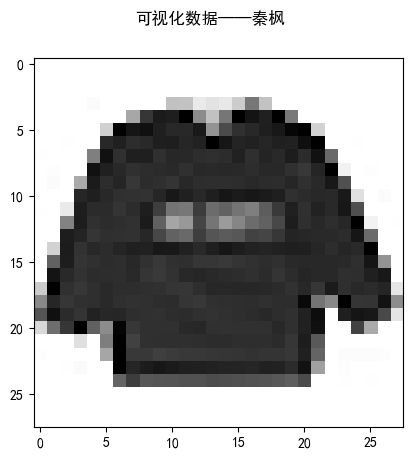

tensor(2)


In [93]:
# 从train_loader中取第一个图片的数据和标签
digit = train_dataset.features[0]
label = train_dataset.labels[0]

# 将数据转换成图片格式并显示
digit_image = digit.view(28, 28)  # 图片大小为28x28
plt.imshow(digit_image, cmap=plt.cm.binary)
plt.suptitle('可视化数据——秦枫', fontsize=12)
plt.show()
print(label)

In [25]:
def KNN_classify(k, dis, train_data, train_label, test_data):
    assert dis == 'E' or dis == 'M', 'dis must be E or M, E代表欧拉距离，M代表曼哈顿距离'
    num_test = test_data.shape[0]  # 测试样本的数量
    label_list = []
    if dis == 'E':
        # 欧拉距离的实现
        for i in range(num_test):
            distances = np.sqrt(np.sum(((train_data - np.tile(test_data[i], (train_data.shape[0], 1))) ** 2), axis=1))
            nearest_k = np.argsort(distances)
            top_k = nearest_k[:k]  # 选取前k个距离
            class_count = {}
            for j in top_k:
                class_count[train_label[j]] = class_count.get(train_label[j], 0) + 1
            sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
            label_list.append(sorted_class_count[0][0])
    else:
        # 曼哈顿距离
        for i in range(num_test):
            distances = np.sum(np.abs(train_data - np.tile(test_data[i], (train_data.shape[0], 1))), axis=1)
            nearest_k = np.argsort(distances)
            top_k = nearest_k[:k]
            class_count = {}
            for j in top_k:
                class_count[train_label[j]] = class_count.get(train_label[j], 0) + 1
            sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
            label_list.append(sorted_class_count[0][0])
    return np.array(label_list)


In [ ]:
#归一化处理

In [43]:
def getXmean(data):
    data = np.reshape(data, (data.shape[0], -1))
    mean_image = np.mean(data, axis=0)
    return mean_image
def centralized(data, mean_image):
    data = data.reshape((data.shape[0], -1))
    data = data.astype(np.float64)
    data -= mean_image  # 减去图像均值，实现领均值化
    return data

(60000, 784)
(60000,)


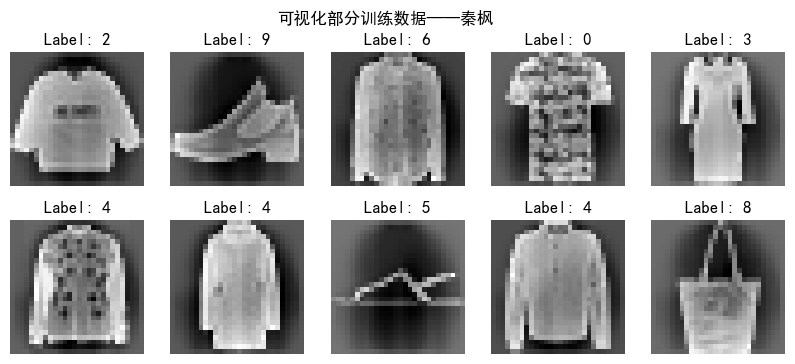

In [92]:
if __name__ == '__main__':
    # 训练数据
    train_data = train_loader.dataset.features.numpy()
    mean_image = getXmean(train_data)  # 计算所有图像均值
    train_data = centralized(train_data, mean_image)  # 对训练集图像进行均值化处理
    print(train_data.shape)
    train_label = train_loader.dataset.labels.numpy()
    print(train_label.shape)

    # 可视化训练数据
    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(train_data[i].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {train_label[i]}')
        plt.axis('off')
    
    plt.suptitle('可视化部分训练数据——秦枫', fontsize=12)
    plt.show()

(1000, 784)
(1000,)


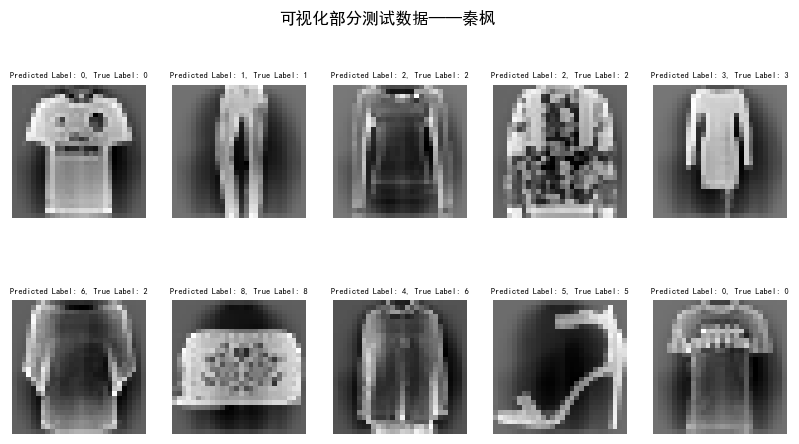

In [96]:
    # 测试数据
    test_data = test_loader.dataset.features[:1000].numpy()
    test_data = centralized(test_data, mean_image)  # 对测试集数据进行均值化处理
    print(test_data.shape)
    test_label = test_loader.dataset.labels[:1000].numpy()
    print(test_label.shape)

    # 可视化测试数据
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(top=0.85)


    gs = plt.GridSpec(2, 5)  # 创建一个网格布局
    gs.update(hspace=0.4)

    for i in range(10):
        ax = plt.subplot(gs[i // 5, i % 5])  # 指定子图位置和大小
        ax.imshow(test_data[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Predicted Label: {test_label_pred[i]}, True Label: {test_label[i]}', fontsize=6)
        ax.axis('off')
    
    plt.suptitle('可视化部分测试数据——秦枫', fontsize=12)
    plt.show()

  

In [94]:
    # 训练
    test_label_pred = KNN_classify(5, 'M', train_data, train_label, test_data)

    # 得到训练准确率
    num_test = test_data.shape[0]
    num_correct = np.sum(test_label == test_label_pred)
    print(num_correct)
    accuracy = float(num_correct) / num_test
    print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
   


871
Got 871 / 1000 correct => accuracy: 0.871000


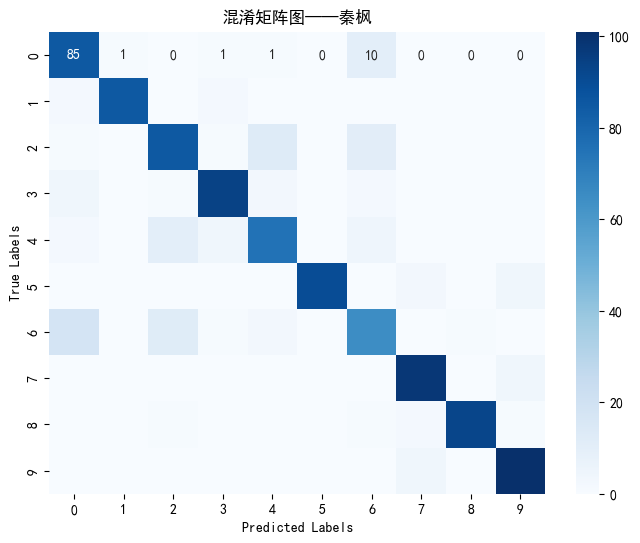

In [89]:
import seaborn as sns

# 计算混淆矩阵
cm = confusion_matrix(test_label, test_label_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.title('混淆矩阵图——秦枫', fontsize=12) 

plt.show()
